In [36]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import OperatorTools as OT
import GridTransferTools as GTT
import TestTools as TT
import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [37]:
nh_min = 8
refRatio = 2

In [38]:
finehalf = list(np.arange(int(nh_min / refRatio)))
omega = BT.Grid(nh_min)
omega.AddPatch(refRatio, finehalf)
nh_max = omega.nh_max
omegaF = BT.Grid(nh_max)

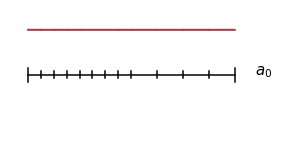

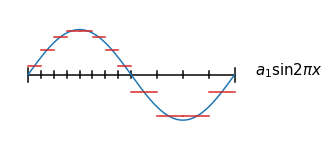

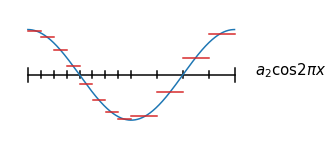

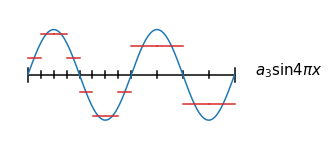

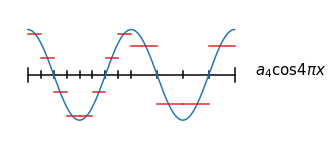

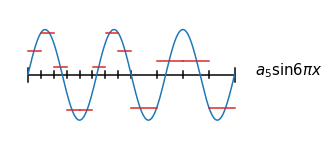

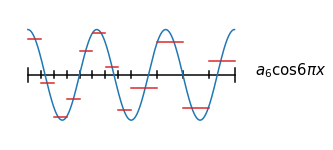

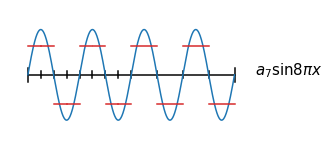

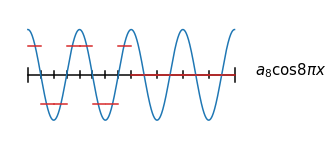

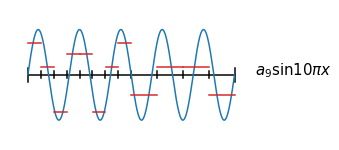

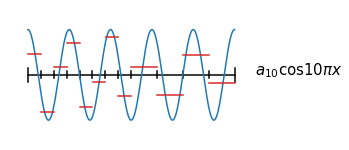

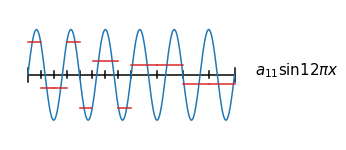

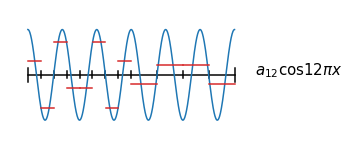

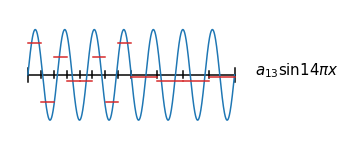

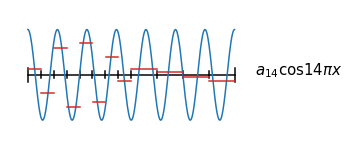

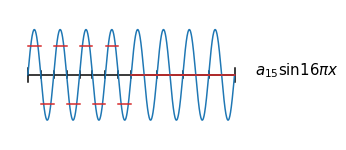

In [39]:
waves = WT.MakeWaves(omega)
wavesF = WT.MakeWaves(omegaF)
PT.PlotWaves(omega, waves = waves)

In [40]:
print(waves)
print(np.shape(waves))

[[ 1.00000000e+00  1.93839179e-01  9.74495358e-01  3.72923229e-01  9.00316316e-01  5.23994577e-01  7.84213304e-01  6.36619772e-01  6.36619772e-01  7.04194890e-01  4.70527982e-01  7.24518620e-01  3.00105439e-01  6.99874143e-01  1.39213623e-01  6.36619772e-01]
 [ 1.00000000e+00  5.52007278e-01  8.26137274e-01  9.00316316e-01  3.72923229e-01  9.25042664e-01 -1.84002426e-01  6.36619772e-01 -6.36619772e-01  1.65227455e-01 -8.30654509e-01 -3.00105439e-01 -7.24518620e-01 -5.93324649e-01 -3.96446856e-01 -6.36619772e-01]
 [ 1.00000000e+00  8.26137274e-01  5.52007278e-01  9.00316316e-01 -3.72923229e-01  1.84002426e-01 -9.25042664e-01 -6.36619772e-01 -6.36619772e-01 -8.30654509e-01  1.65227455e-01 -3.00105439e-01  7.24518620e-01  3.96446856e-01  5.93324649e-01  6.36619772e-01]
 [ 1.00000000e+00  9.74495358e-01  1.93839179e-01  3.72923229e-01 -9.00316316e-01 -7.84213304e-01 -5.23994577e-01 -6.36619772e-01  6.36619772e-01  4.70527982e-01  7.04194890e-01  7.24518620e-01 -3.00105439e-01 -1.39213623e-

In [106]:
def Restrict(omega, waves, wavesF = []):
    print(omega.cells)
    refRatios = omega.refRatios
    nhs = omega.nh
    degFreeds = omega.degFreeds
    cells = omega.cells
    hs = omega.h
    print(degFreeds)
    levels = omega.levels
    if (wavesF == []):
        restrictWaves = waves.copy()
        newDegFreed = degFreeds[0]
    else:
        restrictWaves = wavesF.copy()
        newDegFreed = degFreeds[::-1][0]
    for l in range(levels):
        print(hs)
        refRatio = refRatios[levels - l]
        nh = nhs[levels - l]
        if (wavesF == []):
            degFreed = degFreeds[levels - l]
        else:
            degFreed = nh
        h = 1. / nh
        print('h = ', h)
        restrictOp = np.zeros((newDegFreed, degFreed), float)
        print('shape Op =', np.shape(restrictOp))
        print('shape waves =', np.shape(restrictWaves))
#         restrictH = np.zeros((newDegFreed, degFreed), float)
        weights = np.ones(refRatio, float)
        if (wavesF == []):
            fineReg = np.where(hs == h)[0][::refRatio]
            coarseReg = np.where(hs != h)[0]
        else:
            fineReg = np.where(hs != h)[0]
            coarseReg = np.where(hs == h)[0]
            print('fineReg =', fineReg)
            # print(refRatio * coarseReg)
#     n2h = int(nh / 2)
#     fullWeight = np.zeros((n2h, nh), float)
#     weights = [0.5, 0.5]
        for i in fineReg:
            print('i =', i, int(i / refRatio))
            if (wavesF == []):
                # row = int(i / refRatio)
                restrictOp[int(i / refRatio), i:i + refRatio] = weights
            else:
                restrictOp[::-1][::-1][int((i / refRatio) + (i % refRatio)), i:i + refRatio] = weights
            print(restrictOp)
        restrictOp = restrictOp / refRatio
        restrictH = 2 * restrictOp
        for i in coarseReg:
            
            j = degFreed - 1 - i
            print('j =', j)
            if (wavesF == []):
                restrictOp[::-1, ::-1][j, j] = 1
                restrictH[::-1, ::-1][j, j] = 1
            else:
                restrictOp[j, j] = 1
                restrictH[j, j] = 1
            
            print(restrictOp)
#             row = row + 1
#             restrictOp[row, j] = 1
#             restrictH[row, j] = 1
        print(restrictOp)
        print('')
        print(restrictH)
        hs = restrictH @ hs
        print(hs)
        restrictWaves = restrictOp @ restrictWaves
        newDegFreed = np.shape(restrictWaves)[0]
    return restrictWaves

In [107]:
restrictWaves = Restrict(omega, waves, wavesF = wavesF)
print(restrictWaves)

[[0], [0, 1, 2, 3]]
[8, 12]
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125  0.125  0.125  0.125 ]
h =  0.0625
shape Op = (12, 16)
shape waves = (16, 16)
fineReg = [ 8  9 10 11]
i = 8 4
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
i = 9 4
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


IndexError: index 15 is out of bounds for axis 0 with size 12